In [1]:
from IPython.display import HTML
css_str = '<style> \
.jp-Button path { fill: #616161;} \
text.terms { fill: #616161;} \
.jp-icon-warn0 path {fill: var(--jp-warn-color0);} \
.bp3-button-text path { fill: var(--jp-inverse-layout-color3);} \
.jp-icon-brand0 path { fill: var(--jp-brand-color0);} \
text.terms { fill: #616161;} \
</style>'
display(HTML(css_str ))

In [2]:
import os
if  not 'juxtorpus' in os.listdir():
    os.chdir('../../')
assert 'juxtorpus' in os.listdir(), f"Working directory should be at juxtorpus. But at {os.getcwd()}"
f"Working directory: {os.getcwd()}"

# imports
import pandas as pd
from pathlib import Path
import spacy
from juxtorpus.corpus import Corpus
from juxtorpus.corpus.processors import process
from juxtorpus.corpus.app import App
from juxtorpus.corpus.topic_model import LDA
from juxtorpus.viz.corpus import timeline, timelines, wordcloud, wordclouds
from juxtorpus.viz.item_timeline import ItemTimeline
from juxtorpus.matchers import is_hashtag

from juxtorpus import Jux
from juxtorpus.corpus.corpora import Corpora

import warnings
warnings.filterwarnings('ignore')


# Juxtorpus
## A fast demo on binderhub @ AARNet

# 1. Build a Corpus (Auspol Tweets dataset)

In [3]:
use_cols = ['id', 'created_at', 'source', 'location', 'text', 'retweet_count', 'lang', 'possibly_sensitive', 'tweet_type']
dtypes = ['Int64', 'category', 'string', 'Int64', 'category', 'category', 'category']

df = pd.read_csv(Path('./notebooks/demos/Sample_Auspol_Tweets_Full.csv'), 
                 usecols=use_cols, 
                 dtype={'id': 'Int64', 'source': 'category', 'location':str, 'text':str, 'retweet_count':int, 'lang': 'category', 'tweet_type': 'category'})
df['created_at'] = pd.to_datetime(df['created_at'])
corpus = process(Corpus.from_dataframe(df, col_doc='text', name='auspol'), nlp=spacy.blank('en'))
corpus.name

'auspol'

In [4]:
corpora = Corpora([corpus])
# corpora.add(corpus)   # alternatively
corpora.widget()

In [5]:
df.columns

Index(['id', 'created_at', 'source', 'location', 'text', 'retweet_count',
       'lang', 'possibly_sensitive', 'tweet_type'],
      dtype='object')

## Exploring the Corpus

In [6]:
corpus = corpora['auspol']
print('This table summarise the basic information of the corpus')
corpus.summary()

This table summarise the basic information of the corpus


Corpus Type                                                    SpacyCorpus
Number of Documents                                                 100000
Number of Total Words                                              1544294
Size of Vocabulary                                                   40469
mean Words per Document                                                 15
min Words per Document                                                   0
max Words per Document                                                  59
metas                    id, created_at, source, location, retweet_coun...

### Corpus Wordcloud

Generate a word cloud with one line of code


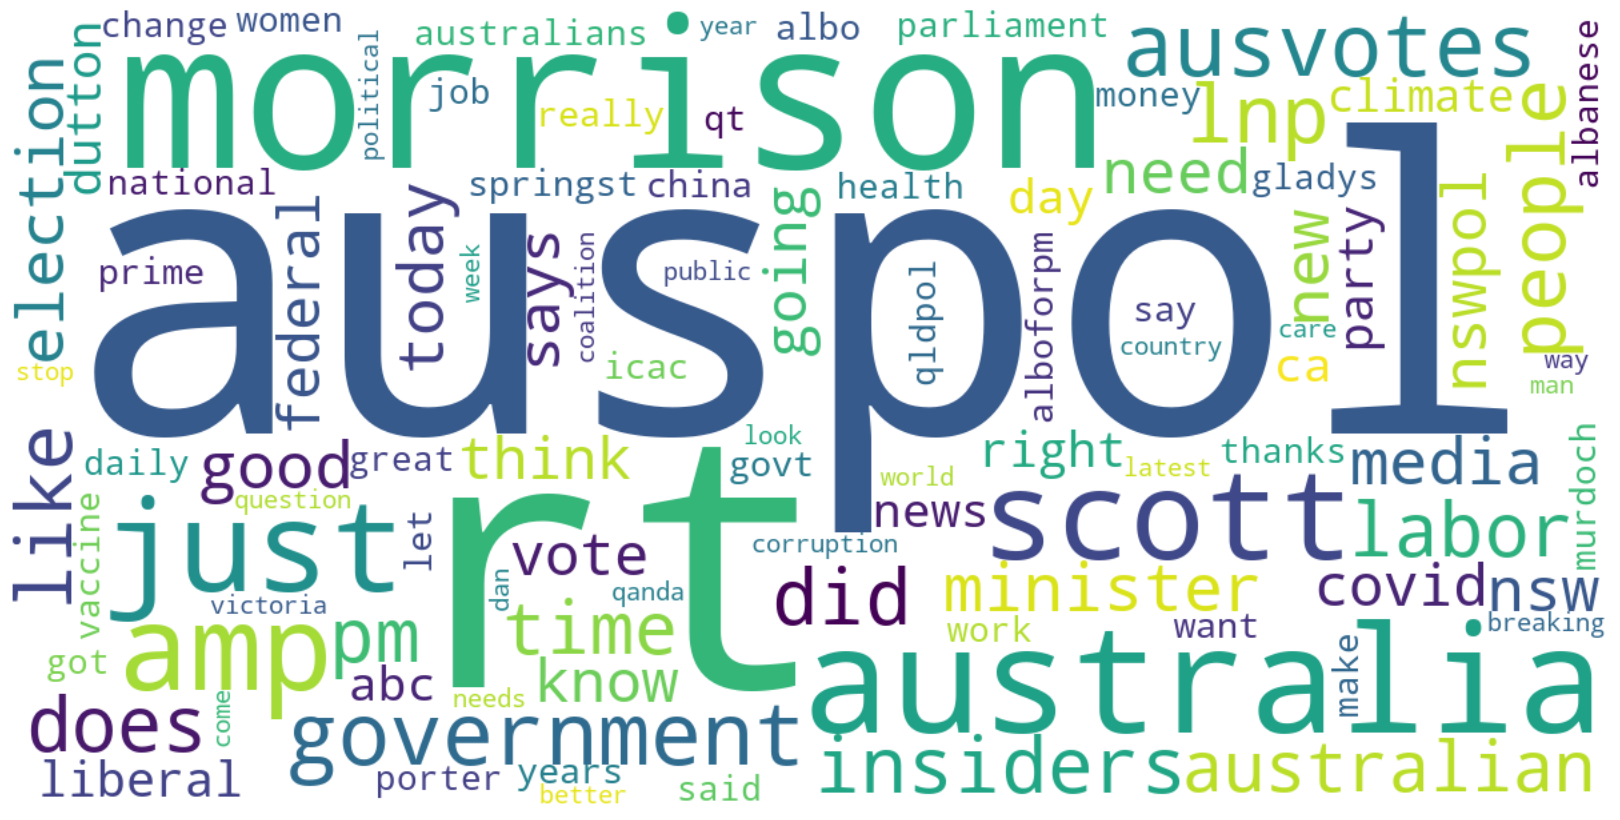

In [7]:
MAX_WORDS = 100
TYPE = 'word'
# TYPE = 'hashtag'
# TYPE = 'mention'
print('Generate a word cloud with one line of code')
corpus.viz.wordcloud(max_words=MAX_WORDS, word_type=TYPE)

Or make a wordcloud focusing on another predefined pattern - Hashtag


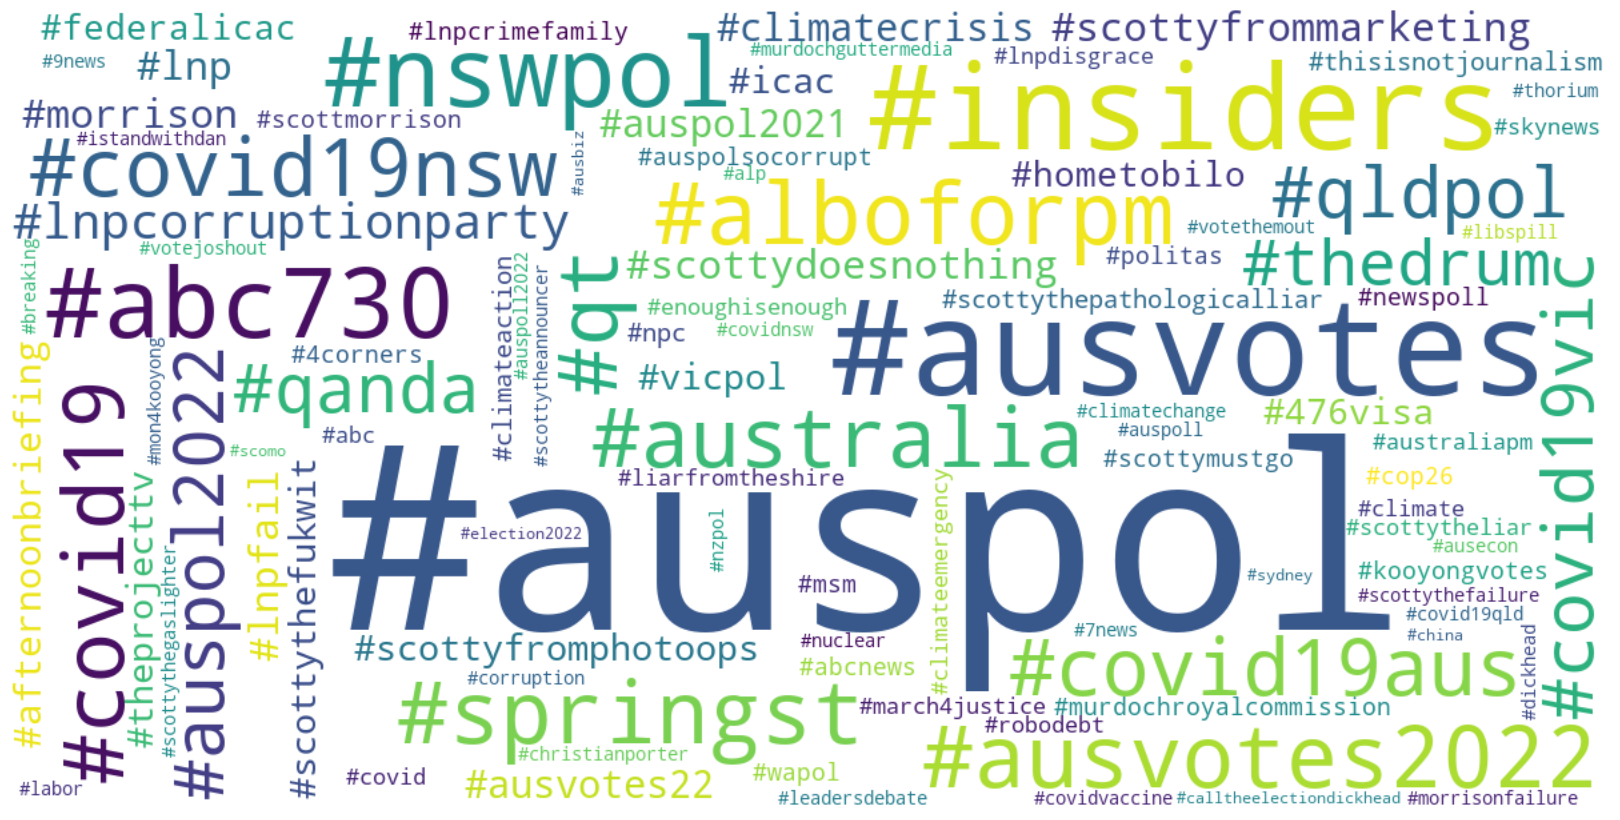

In [8]:
MAX_WORDS = 100
# TYPE = 'word'
TYPE = 'hashtag'
# TYPE = 'mention'
print('Or make a wordcloud focusing on another predefined pattern - Hashtag')
corpus.viz.wordcloud(max_words=MAX_WORDS, word_type=TYPE)

### A Timeline of Daily Tweets Number

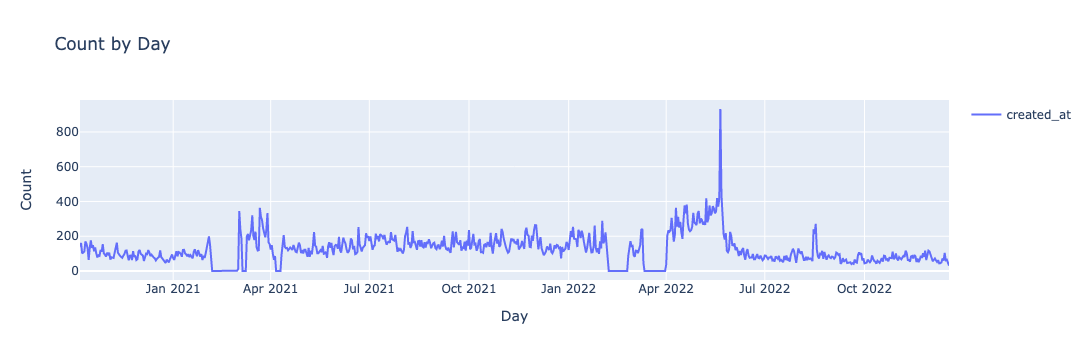

In [9]:
# FREQ = '1w'
# FREQ = '1m'
FREQ = '1d'
COL_TIME = 'created_at'
corpus.viz.timeline(COL_TIME, freq=FREQ)

Can also aggregate the data by different periods, e.g. weekly tweeting numbers


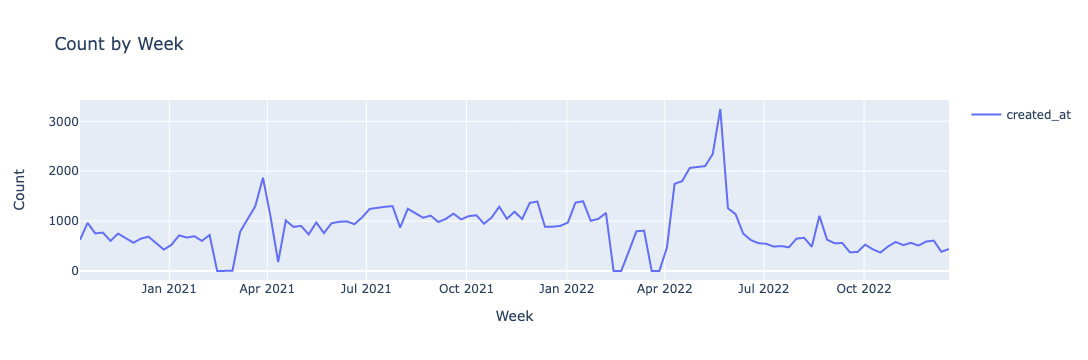

In [10]:
print('Can also aggregate the data by different periods, e.g. weekly tweeting numbers')
corpus.viz.timeline(COL_TIME, freq='1w')

In [11]:
COL_TIME = 'created_at'
FREQ = '1w'

# user defined function in creating a custom dtm (document-term-matrix)
matcher = is_hashtag(corpus.nlp.vocab)
def extract_hashtags(doc): return [doc[s:e].text.lower() for _, s, e in matcher(doc)]
corpus.create_custom_dtm(extract_hashtags)

print('Extract all Hashtags and display their weekly trends\n - Click legend to deselect items\n - Use the search box to display specific hashtag')
item_timeline = ItemTimeline.from_corpus(corpus, COL_TIME, FREQ, custom_dtm=True)
item_timeline.render()

Extract all Hashtags and display their weekly trends
 - Click legend to deselect items
 - Use the search box to display specific hashtag


FigureWidget({
    'data': [{'marker': {'color': 'rgba(196,250,0,1.0)'},
              'mode': 'lines+markers+…

# Corpus Slicer - creating a subcorpus

## Slice the corpus by categorical metadata - Single or Multiple Choices

In [12]:
temp_corpus = corpora['auspol'].slicer.filter_by_item('lang', 'en')
temp_corpus.name = 'auspol-en'
corpora.add(temp_corpus)
#
temp_corpus = corpora['auspol-en'].slicer.filter_by_item('source', ['Twitter for iPad', 'Twitter for iPhone', 'Twitter for Mac'])
temp_corpus.name = 'Apple'
corpora.add(temp_corpus)

## Slice the corpus by time

In [13]:
temp_corpus = corpora['auspol-en'].slicer.filter_by_datetime('created_at', start='01/03/2022', end='01/06/2022')
temp_corpus.name = 'Autumn22'
corpora.add(temp_corpus)
#
temp_corpus = corpora['auspol-en'].slicer.filter_by_datetime('created_at', start='01/09/2021', end='01/12/2021')
temp_corpus.name = 'Spring21'
corpora.add(temp_corpus)

## Slice the corpus by conditions, customised functions or slice the sub-corpora


In [14]:
import re
temp_corpus = corpora['auspol-en'].slicer.filter_by_condition('retweet_count', lambda cnt: cnt>3)
temp_corpus.name = 'rt5+'
corpora.add(temp_corpus)
#
L_func = '''lambda x: re.match(r'^.*android.*$', x, re.IGNORECASE) is not None'''
temp_corpus = corpora['auspol-en'].slicer.filter_by_condition('source', eval(L_func))
temp_corpus.name = 'Android'
corpora.add(temp_corpus)

## Interactive Widget for Slicing the Corpora

In [28]:
corpora.widget()

# Text Analysis on Corpus

### All exploration can be easily repeated on sub-corpus, e.g. Wordcloud

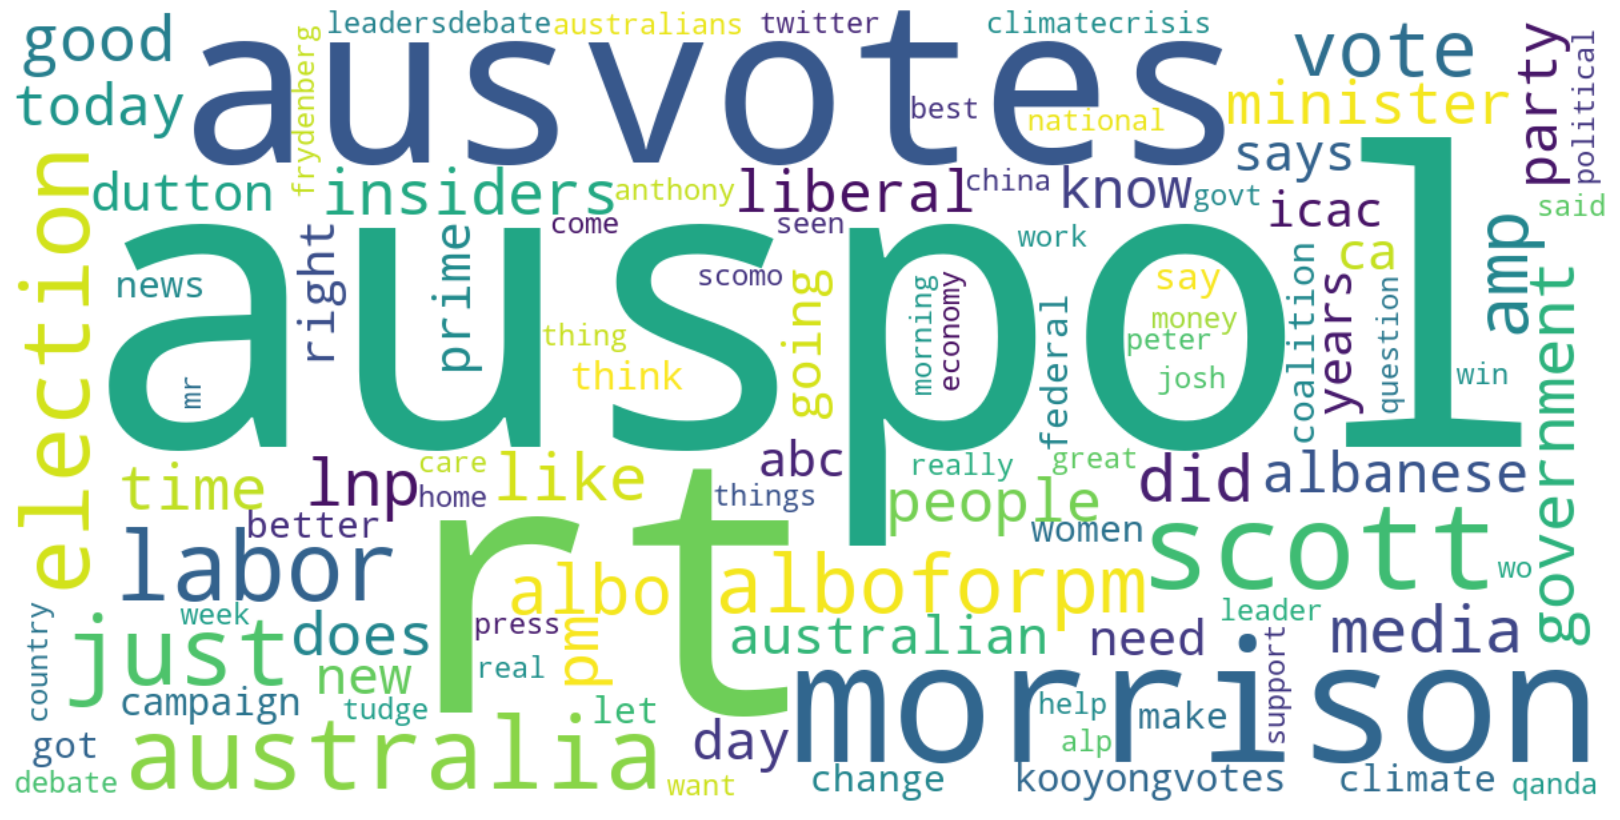

In [33]:
corpora['Autumn22'].viz.wordcloud(max_words=MAX_WORDS, word_type='word')

## LDA Topic Modelling + merge the outcome back to corpus

In [16]:
NUM_TOPICS = 10
lda = LDA(corpora['Autumn22'], num_topics=NUM_TOPICS).build('tf')
lda.add_results_to_corpus()
lda.widget()

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.143899 -0.012400       1        1  27.964804
9     -0.103120 -0.015499       2        1  13.583172
2     -0.042888 -0.068497       3        1   9.545496
6     -0.031282  0.136984       4        1   9.166006
0      0.003641 -0.030190       5        1   8.887739
4     -0.001195 -0.085868       6        1   8.390045
5      0.000853  0.097740       7        1   7.191067
8      0.048260  0.019582       8        1   6.336729
1      0.090353 -0.050006       9        1   4.970986
7      0.179277  0.008154      10        1   3.963955, topic_info=            Term          Freq         Total Category  logprob  loglift
2197      auspol  13888.000000  13888.000000  Default  30.0000  30.0000
38179       vote    602.000000    602.000000  Default  29.0000  29.0000
30174         rt  10593.000000  10593.000000  Default  28.0000  28.0000
2250   australia    733.000000    733.000000  Default  27.0000  27.0000
2390    ausvotes   2599.000000   2599.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
14803       good     25.598444    400.313481  Topic10  -5.5420   0.4782
21765      media     25.581100    438.126629  Topic10  -5.5427   0.3873
22749    morning     20.453629    163.718974  Topic10  -5.7664   1.1479
25947     people     20.946986    361.203997  Topic10  -5.7425   0.3805
22306   minister     20.759275    346.677925  Topic10  -5.7515   0.4125

[721 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
91         4  0.921343       abetz
129        5  0.966178  aboriginal
187       10  0.909497    abundant
196        2  0.986302     abusive
224        3  0.912249      accept
...      ...       ...         ...
39692      6  0.070915       years
39692      7  0.070915       years
39692      9  0.133487       years
39760      8  0.954572        york
39801      4  0.933023     youtube

[1478 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 10, 3, 7, 1, 5, 6, 9, 2, 8])

### Create sub-corpus based on the topic model associations

In [27]:
sel_topics = {'a': 4,
             'b': 10}
for t, n in sel_topics.items():
    temp_corpus = corpora['Autumn22'].slicer.filter_by_range('#lda_topic_{}'.format(n), min_=0.5)
    temp_corpus.name = 'Autumn_T'+t
    corpora.add(temp_corpus)

['auspol',
 'auspol-en',
 'Apple',
 'Autumn22',
 'Spring21',
 'rt5+',
 'Android',
 'Autumn_Ta',
 'Autumn_Tb']

## Daily trends of the selected topics

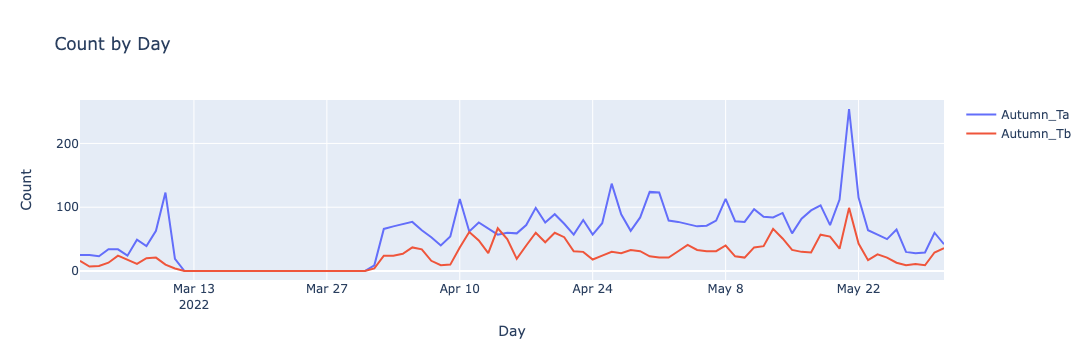

In [35]:
COL_TIME = 'created_at'
FREQ = '1d'
timelines(corpora, ['Autumn_Ta', 'Autumn_Tb'], COL_TIME, FREQ)

# Jux - Compare and highlight the contrasts between any pair of corpora

## Normal Corpus Wordcloud - Side by side, TFIDF

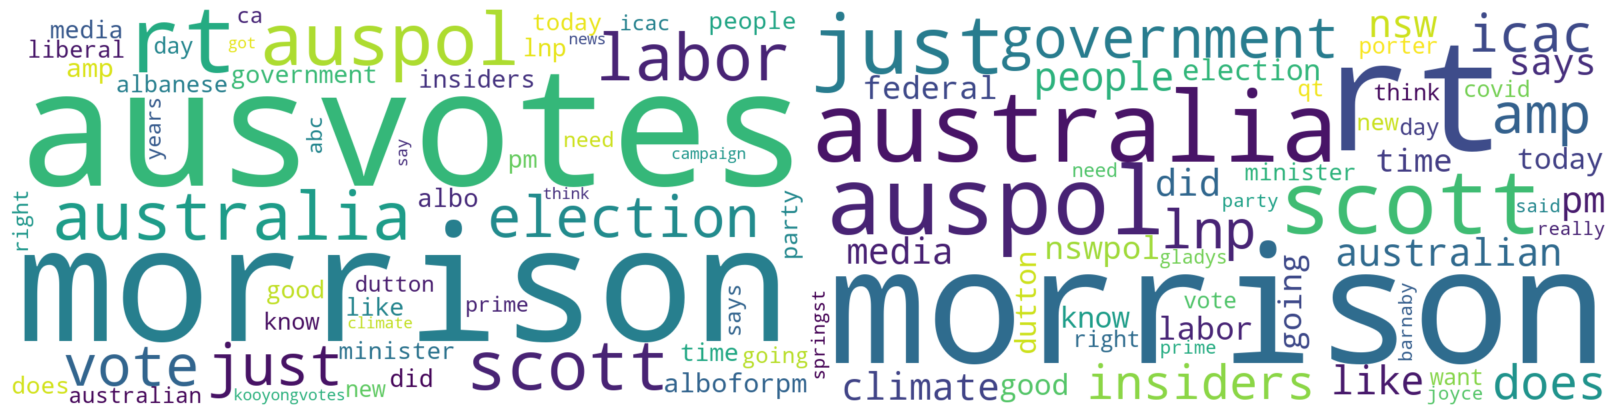

In [36]:
MAX_WORDS = 50
# METRIC = 'tf'
METRIC = 'tfidf'
wordclouds(corpora, ['Autumn22', 'Spring21'], max_words=MAX_WORDS, metric=METRIC)

## Jux Polarity Wordcloud - term frequency

AttributeError: 'NoneType' object has no attribute 'corpus_0'

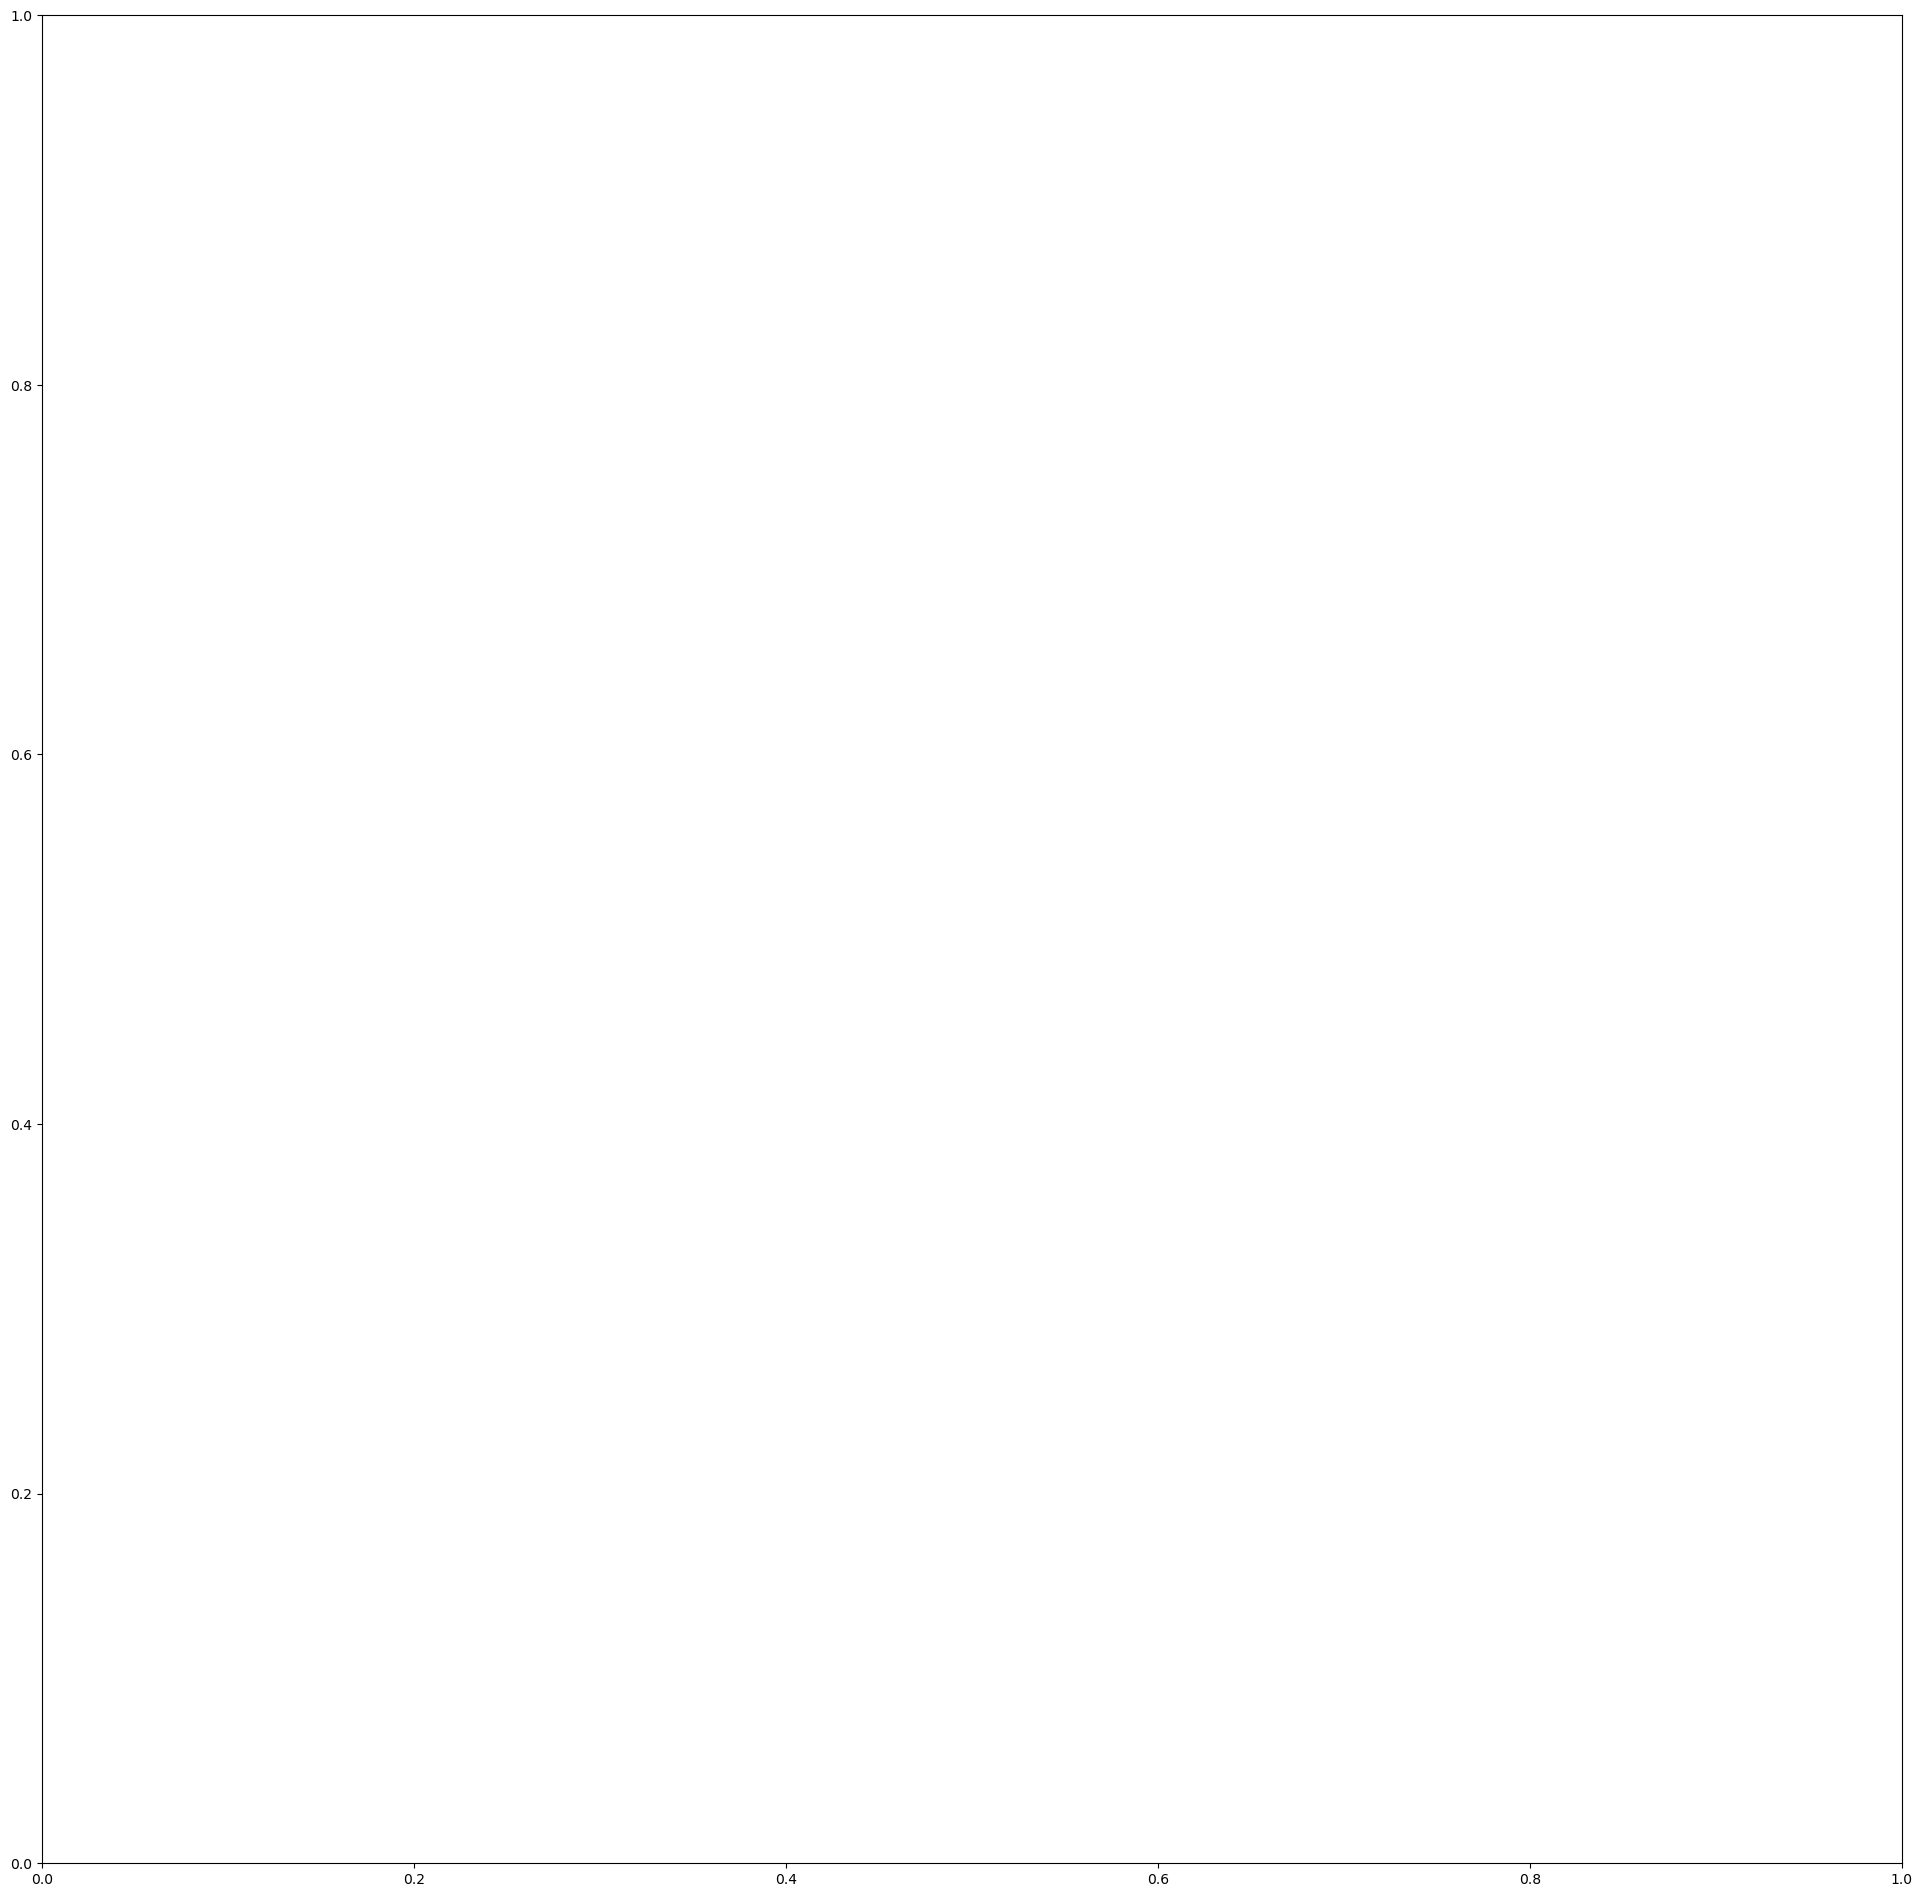

In [37]:
METRIC = 'tf'
# METRIC = 'tfidf'
# METRIC = 'log_likelihood'
TOP = 80
Jux(corpora['Autumn22'], corpora['Spring21']).polarity.wordcloud(METRIC, top=TOP, colours=('blue', 'red'))

### User defined tokenising function

AttributeError: 'NoneType' object has no attribute 'corpus_0'

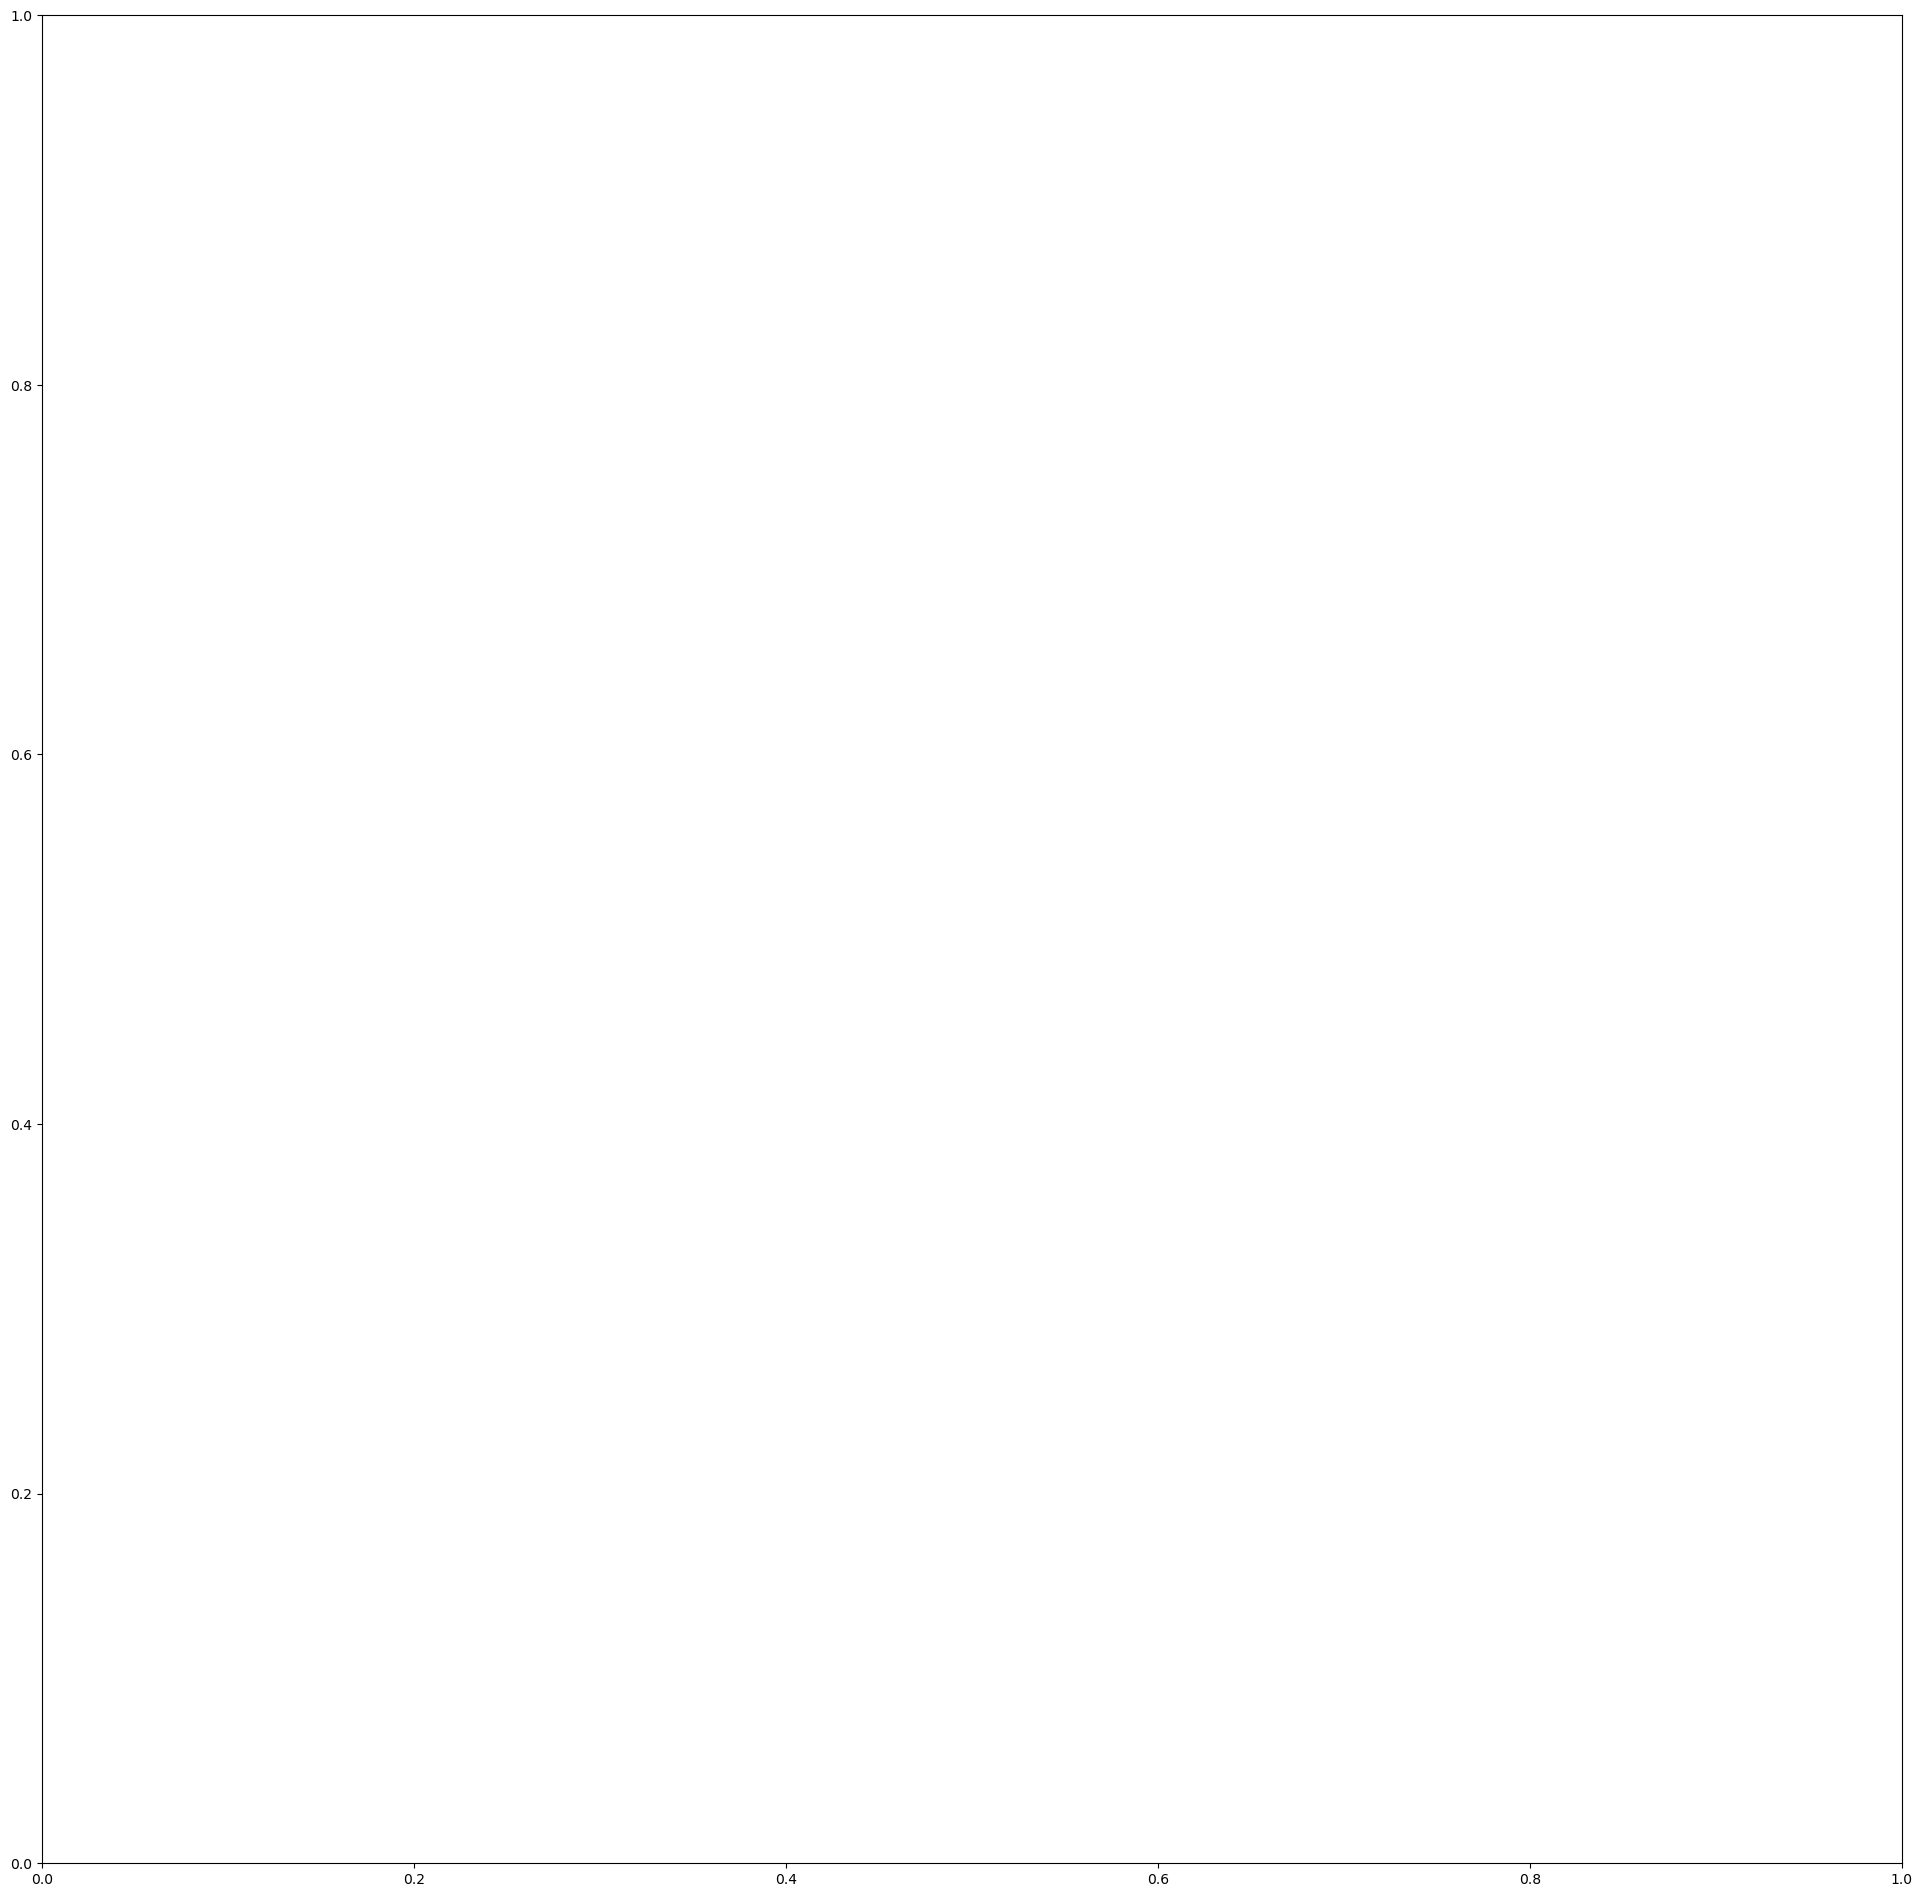

In [38]:
METRIC = 'tf'

# getting hashtags using a user defined function
Jux(corpora['Spring21'], corpora['Autumn22']).\
    polarity.wordcloud(METRIC, top=TOP, colours=('blue', 'red'), tokeniser_func=extract_hashtags)

In [25]:
auspol = corpora['auspol']
corpora['android'] = auspol.slicer.filter_by_item('source', 'Twitter for Android')
corpora['iphone'] = auspol.slicer.filter_by_item('source', 'Twitter for iPhone')
corpora['2021'] = auspol.slicer.filter_by_datetime('created_at', start='01-01-2021', end='01-01-2022')
corpora['2022'] = auspol.slicer.filter_by_datetime('created_at', start='01-01-2022', end='01-01-2023')

AttributeError: 'NoneType' object has no attribute 'corpus_0'

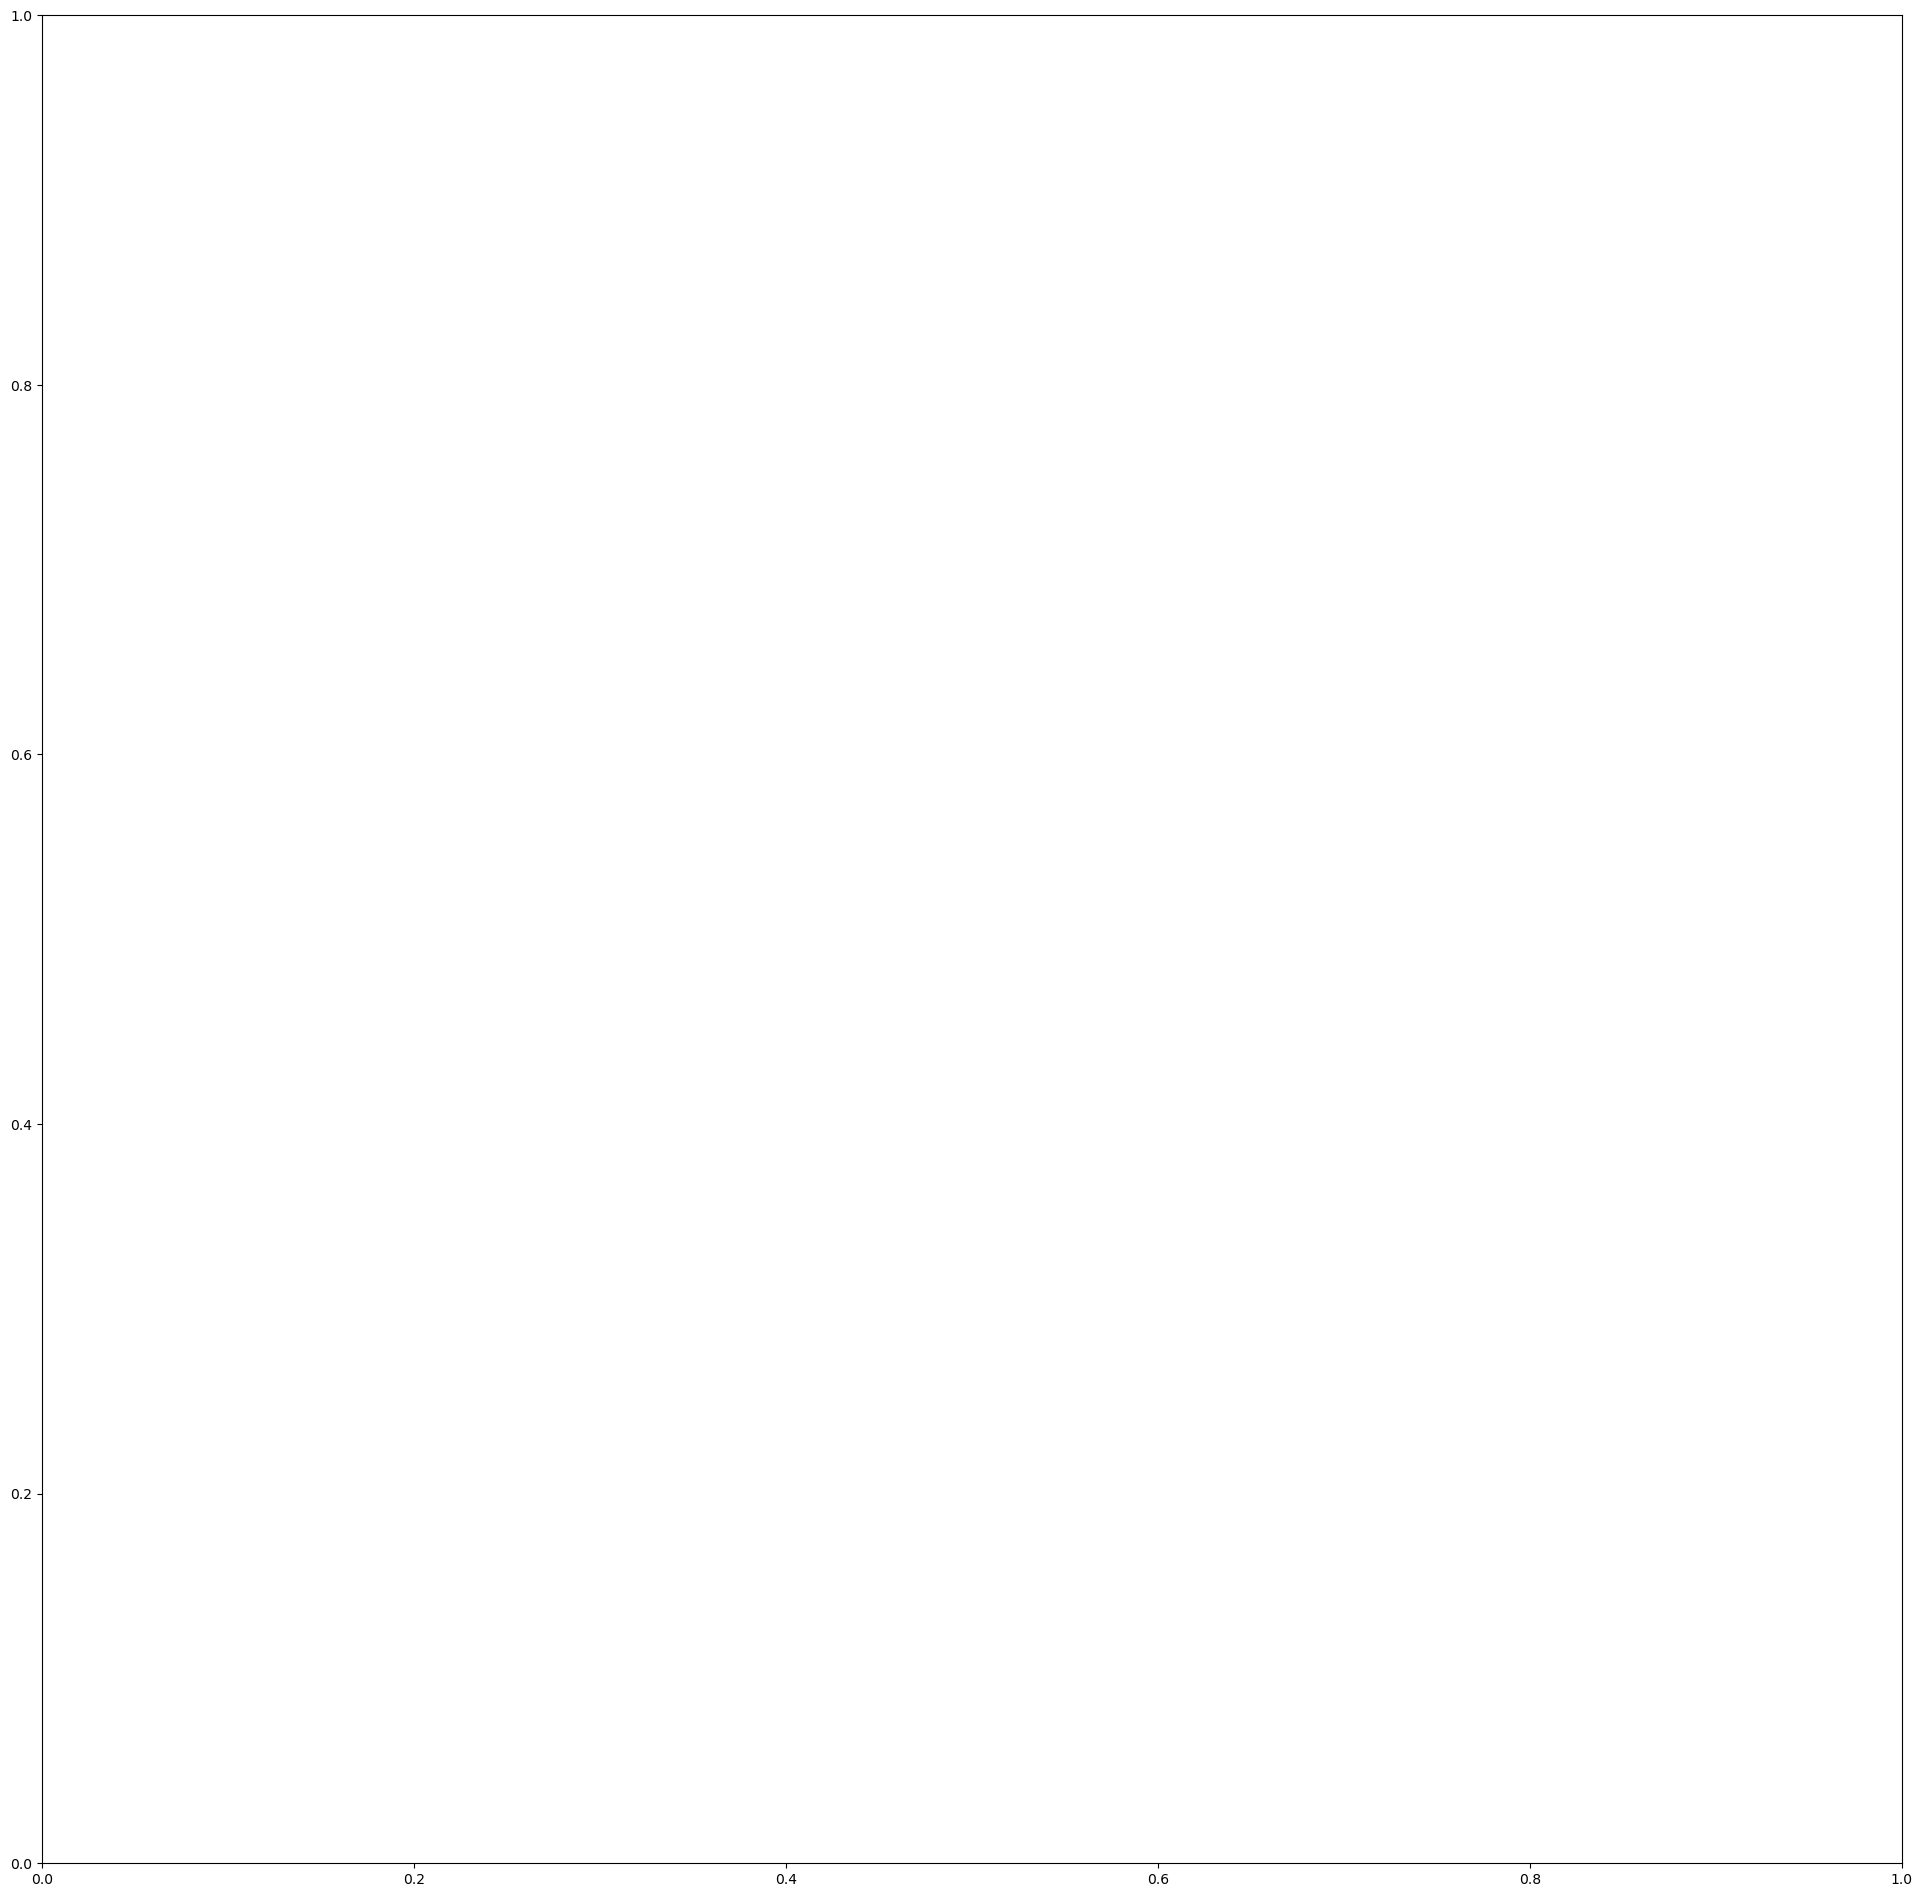

In [41]:
corpus_pairs = [
    ('Android', 'Apple', ('blue', 'red')),
    ('Spring21', 'Autumn22', ('cyan', 'magenta')),
]

for pair in corpus_pairs:
    colours = pair[2]
    Jux(corpora[pair[0]], corpora[pair[1]]).polarity.wordcloud('tf', top=TOP, colours=colours)

# Keyword Analysis based on Log Likelihood

Future plans: using Log likelihood to analyse keywords (currently being integrated)


Rayson Paul., Berridge D. and Francis B. (2004). Extending the Cochran rule for the comparison of word frequencies between corpora. In Volume II of Purnelle G., Fairon C., Dister A. (eds.) Le poids des mots: Proceedings of the 7th International Conference on Statistical analysis of textual data (JADT 2004), Louvain-la-Neuve, Belgium, March 10-12, 2004, Presses universitaires de Louvain, pp. 926 - 936. ISBN 2-930344-50-4.
https://ucrel.lancs.ac.uk/llwizard.html

In [39]:
def style_corpus(row, colour):
    return ['color:blue;']*len(row) if colour[row.name] else ['color:red;']*len(row)

jun_ft = corpora['Spring21'].dtm.freq_table().series
jan_ft = corpora['Autumn22'].dtm.freq_table().series
df_ft = pd.concat([jun_ft.rename('Spring21'), jan_ft.rename('Autumn22')], axis=1, join='outer').fillna(0)
colour = df_ft['Spring21'] > df_ft['Autumn22']

In [40]:
llv = Jux(corpora['Spring21'], corpora['Autumn22']) \
    .stats.log_likelihood_and_effect_size() \
    .sort_values(by='log_likelihood_llv', ascending=False)
llv.iloc[:30].style \
    .apply(lambda row: style_corpus(row, colour), axis=1)

# Red - Overused in January Corpus, Blue - Overused in July Corpus

# Closing

+ Release is planned tentatively in **May**.
+ We will eventually integrate the ATAP tools together so you can easily access it under Corpus.
+ Stay tuned at https://www.atap.edu.au/
+ Feedback Survey at the end of the full workshop.
+ Questions - I'll be around or email me at huen.chan@sydney.edu.au